<a href="https://colab.research.google.com/github/Jarcos09/Tareas/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente :** Verónica Sandra Guzmán de Valle

### 📊 **Proyecto | Base de Datos de Big Data**

#### 📅 **04 de mayo de 2025**

* 🧑‍💻 **A01795941 :** Juan Carlos Pérez Nava




In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('proyectos/librerias'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graficas import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, lit, count, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import pandas as pd
from pyspark.ml.feature import Imputer



In [ ]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Path to dataset files:", path)

Path to dataset files: /home/jarcos/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13


In [ ]:
spark = SparkSession.builder.master("local[*]").appName("CargarCSV").config("spark.driver.memory", "40g").config("spark.executor.memory", "20g").getOrCreate()
df_accident = spark.read.option("header", True).option("inferSchema", True).csv(path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 18:31:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
df_accident.show(5)

25/05/20 18:31:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [ ]:
columnas_clave = [
    "ID", "Weather_Condition","Precipitation(in)","Severity", "City", "State",
    "Temperature(F)", "Humidity(%)", "Visibility(mi)","Wind_Direction","Wind_Speed(mph)","Crossing","Junction","Railway",
    "Roundabout","Stop","Sunrise_Sunset","Traffic_Calming","Traffic_Signal"]

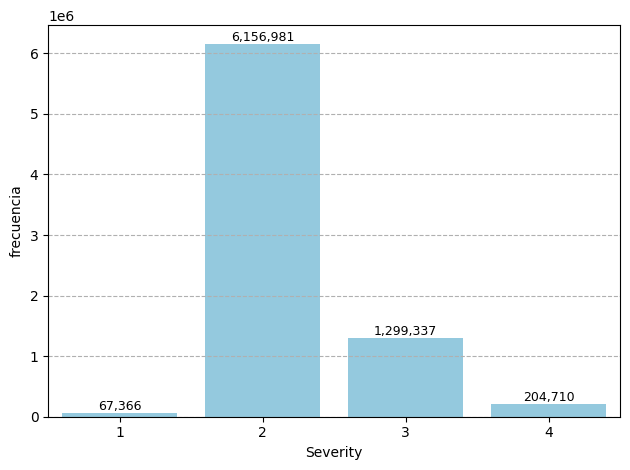

In [ ]:
barras_categorica(df_accident,'Severity')

**Obtención de las estadísticas descriptivas de las características categóricas**

# Particionamiento

El particionamiento del conjunto de datos se basa en las condiciones climáticas y la severidad del accidente, dividiéndolo en múltiples subconjuntos según combinaciones específicas de estas características.

In [ ]:
df_accident = df_accident.select(columnas_clave)

df_accident.write.mode("overwrite").partitionBy("Severity").parquet("us_accidents_partitioned")

accident_sev_1 = spark.read.parquet("us_accidents_partitioned/Severity=1")
accident_sev_2 = spark.read.parquet("us_accidents_partitioned/Severity=2")
accident_sev_3 = spark.read.parquet("us_accidents_partitioned/Severity=3")
accident_sev_4 = spark.read.parquet("us_accidents_partitioned/Severity=4")

In [ ]:
accident_sev_1.show(5)

+--------+-----------------+-----------------+----------------+-----+--------------+-----------+--------------+--------------+---------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+
|      ID|Weather_Condition|Precipitation(in)|            City|State|Temperature(F)|Humidity(%)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|
+--------+-----------------+-----------------+----------------+-----+--------------+-----------+--------------+--------------+---------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+
|A-362864|            Clear|             NULL|         Augusta|   GA|          57.9|       32.0|          10.0|            NE|            8.1|   false|   false|  false|     false|false|           Day|          false|         false|
|A-365033|    Mostly Cloudy|             NULL|   Downers Grove|   IL|   

# Imputando valores faltantes

In [ ]:
def obten_nulos(particion):

  print(f"📌 Particiones: {particion.rdd.getNumPartitions()}")
  print(f"📊 Total de filas en la partición: {particion.count()}")
  print(f"🗂️ Número de columnas en la partición: {len(particion.columns)}")

  info_nulos = {}
  cols_nulos = {}

  total_rows = particion.count()

  registros_totales = particion.count()

  # Contar valores nulos por columna

  cols_nulos = particion.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in particion.columns]
    )

  # Convertir los resultados en un diccionario
  info_nulos = {c: cols_nulos.select(c).collect()[0][0] for c in particion.columns}

  # Filtrar solo las columnas con valores nulos
  cols_nulos = {c: {"count": v, "percent": (v / total_rows) * 100} for c, v in info_nulos.items() if v > 0}

  # Validar si existen nulos
  if not cols_nulos:
        print("✅ No existen valores nulos en la partición.")
        return


  df_resumen_nulos = spark.createDataFrame(
    [(c, d["count"], round(d["percent"], 2)) for c, d in cols_nulos.items()],
    ["Columna", "Total de nulos", "%"]
  )

  df_resumen_nulos.orderBy(col("Total de nulos").desc()).show(truncate=False)


In [ ]:
def imputacion_valores(particion):


  print("✅ Se realiza la imputación utilizando los siguientes valores:\n")

  moda_Weather = particion.groupBy("Weather_Condition").count().orderBy(col("count").desc()).first()["Weather_Condition"]
  moda_City = particion.groupBy("City").count().orderBy(col("count").desc()).first()["City"]
  moda_Sunset = particion.groupBy("Sunrise_Sunset").count().orderBy(col("count").desc()).first()["Sunrise_Sunset"]
  moda_wub = particion.groupBy("Wind_Direction").count().orderBy(col("count").desc()).first()["Wind_Direction"]

  media_Temperature = particion.select(avg("Temperature(F)")).collect()
  media_Humidity = particion.select(avg("Humidity(%)")).collect()
  media_Visibility = particion.select(avg("Visibility(mi)")).collect()
  media_Precipitation = particion.select(avg("Precipitation(in)")).collect()
  media_Wind_Speed = particion.select(avg("Wind_Speed(mph)")).collect()

  print(f"🌡️ Temperatura promedio: {round(media_Temperature[0][0], 2)}")
  print(f"💧 Humedad promedio: {round(media_Humidity[0][0], 2)}")
  print(f"👀 Visibilidad promedio: {round(media_Visibility[0][0], 2)}")
  print(f"🌧️ Precipitación promedio: {round(media_Precipitation[0][0], 2)}")
  print(f"🌬️ Velocidad del viento promedio: {round(particion.select(avg("Wind_Speed(mph)")).collect()[0][0], 2)}")

  print(f"☁️ Condición meteorológica más frecuente: {moda_Weather}")
  print(f"🏙️ Ciudad más frecuente: {moda_City}")
  print(f"🌅 Hora de atardecer más frecuente: {moda_Sunset}")
  print(f"🌬️ Dirección del viento más frecuente: {moda_wub}")

  imputer_num = Imputer(
    inputCols=["Temperature(F)", "Humidity(%)", "Visibility(mi)","Precipitation(in)","Wind_Speed(mph)"],
    outputCols=["Temperature(F)", "Humidity(%)", "Visibility(mi)","Precipitation(in)","Wind_Speed(mph)"]
  ).setStrategy("mean")

  particion = imputer_num.fit(particion).transform(particion)
  particion = particion.na.fill({"Weather_Condition": moda_Weather, "City": moda_City,
                                 "Sunrise_Sunset": moda_Sunset,"Wind_Direction":moda_wub})

  particion_modificada = particion

  print("\n🔍 Se validan nuevamente los valores nulos para corroborar la imputación.\n")

  obten_nulos(particion_modificada)

  return particion_modificada




In [ ]:
obten_nulos(accident_sev_1)

📌 Particiones: 13
📊 Total de filas en la partición: 67366
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+----+
|Columna          |Total de nulos|%   |
+-----------------+--------------+----+
|Precipitation(in)|3916          |5.81|
|Wind_Speed(mph)  |1352          |2.01|
|Humidity(%)      |1249          |1.85|
|Wind_Direction   |1210          |1.8 |
|Temperature(F)   |1110          |1.65|
|Weather_Condition|954           |1.42|
|Visibility(mi)   |935           |1.39|
|Sunrise_Sunset   |204           |0.3 |
|City             |3             |0.0 |
+-----------------+--------------+----+



In [ ]:
imp_sev_1 = imputacion_valores(accident_sev_1)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 72.42
💧 Humedad promedio: 61.91
👀 Visibilidad promedio: 9.48
🌧️ Precipitación promedio: 0.01
🌬️ Velocidad del viento promedio: 7.14
☁️ Condición meteorológica más frecuente: Fair
🏙️ Ciudad más frecuente: Tucson
🌅 Hora de atardecer más frecuente: Day
🌬️ Dirección del viento más frecuente: CALM

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 13
📊 Total de filas en la partición: 67366
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


In [ ]:
obten_nulos(accident_sev_2)

📌 Particiones: 17
📊 Total de filas en la partición: 6156981
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+----+
|Columna          |Total de nulos|%   |
+-----------------+--------------+----+
|Precipitation(in)|1489966       |24.2|
|Wind_Speed(mph)  |398896        |6.48|
|Wind_Direction   |143899        |2.34|
|Humidity(%)      |138627        |2.25|
|Visibility(mi)   |138237        |2.25|
|Weather_Condition|134781        |2.19|
|Temperature(F)   |130158        |2.11|
|Sunrise_Sunset   |20079         |0.33|
|City             |217           |0.0 |
+-----------------+--------------+----+



In [ ]:
imp_sev_2 = imputacion_valores(accident_sev_2)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 61.55
💧 Humedad promedio: 64.67
👀 Visibilidad promedio: 9.09
🌧️ Precipitación promedio: 0.01
🌬️ Velocidad del viento promedio: 7.57
☁️ Condición meteorológica más frecuente: Fair
🏙️ Ciudad más frecuente: Miami
🌅 Hora de atardecer más frecuente: Day
🌬️ Dirección del viento más frecuente: CALM

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 17
📊 Total de filas en la partición: 6156981
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


In [ ]:
obten_nulos(accident_sev_3)

📌 Particiones: 14
📊 Total de filas en la partición: 1299337
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+-----+
|Columna          |Total de nulos|%    |
+-----------------+--------------+-----+
|Precipitation(in)|640382        |49.29|
|Wind_Speed(mph)  |150046        |11.55|
|Visibility(mi)   |30511         |2.35 |
|Weather_Condition|30295         |2.33 |
|Humidity(%)      |27322         |2.1  |
|Temperature(F)   |25977         |2.0  |
|Wind_Direction   |23376         |1.8  |
|Sunrise_Sunset   |689           |0.05 |
|City             |13            |0.0  |
+-----------------+--------------+-----+



In [ ]:
imp_sev_3 = imputacion_valores(accident_sev_3)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 62.2
💧 Humedad promedio: 65.38
👀 Visibilidad promedio: 9.09
🌧️ Precipitación promedio: 0.02
🌬️ Velocidad del viento promedio: 8.32
☁️ Condición meteorológica más frecuente: Clear
🏙️ Ciudad más frecuente: Los Angeles
🌅 Hora de atardecer más frecuente: Day
🌬️ Dirección del viento más frecuente: Calm

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 14
📊 Total de filas en la partición: 1299337
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


In [ ]:
obten_nulos(accident_sev_4)

📌 Particiones: 12
📊 Total de filas en la partición: 204710
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+-----+
|Columna          |Total de nulos|%    |
+-----------------+--------------+-----+
|Precipitation(in)|69322         |33.86|
|Wind_Speed(mph)  |20939         |10.23|
|Weather_Condition|7429          |3.63 |
|Visibility(mi)   |7415          |3.62 |
|Humidity(%)      |6946          |3.39 |
|Wind_Direction   |6721          |3.28 |
|Temperature(F)   |6608          |3.23 |
|Sunrise_Sunset   |2274          |1.11 |
|City             |20            |0.01 |
+-----------------+--------------+-----+



In [ ]:
imp_sev_4 = imputacion_valores(accident_sev_4)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 58.14
💧 Humedad promedio: 67.3
👀 Visibilidad promedio: 9.06
🌧️ Precipitación promedio: 0.01
🌬️ Velocidad del viento promedio: 7.66
☁️ Condición meteorológica más frecuente: Fair
🏙️ Ciudad más frecuente: Atlanta
🌅 Hora de atardecer más frecuente: Day
🌬️ Dirección del viento más frecuente: CALM

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 12
📊 Total de filas en la partición: 204710
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


# Preparando datos

In [ ]:
imp_sev_1 = imp_sev_1.withColumn("Severity", lit(1))
imp_sev_2 = imp_sev_2.withColumn("Severity", lit(2))
imp_sev_3 = imp_sev_3.withColumn("Severity", lit(3))
imp_sev_4 = imp_sev_4.withColumn("Severity", lit(4))

listado_particiones = [imp_sev_1, imp_sev_2, imp_sev_3, imp_sev_4]

tamaño_muestra = min(particion.count() for particion in listado_particiones)  # Tomar el tamaño del DF más pequeño

print(tamaño_muestra)

muestra_particion = [particion.sample(fraction=tamaño_muestra / particion.count(), seed=25) for particion in listado_particiones]

muestra = muestra_particion[0].union(muestra_particion[1]).union(muestra_particion[2]).union(muestra_particion[3])

muestra.show(5)


67366
+--------+-----------------+--------------------+----------------+-----+--------------+-----------+--------------+--------------+---------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------+
|      ID|Weather_Condition|   Precipitation(in)|            City|State|Temperature(F)|Humidity(%)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|Severity|
+--------+-----------------+--------------------+----------------+-----+--------------+-----------+--------------+--------------+---------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------+
|A-362864|            Clear|0.005067454688731288|         Augusta|   GA|          57.9|       32.0|          10.0|            NE|            8.1|   false|   false|  false|     false|false|           Day|          false|         false|       1|
|A-365033|    Most

In [ ]:
muestra.groupBy("Severity").count().show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|67366|
|       2|67022|
|       3|67708|
|       4|67674|
+--------+-----+



In [ ]:
categoricas = ["Weather_Condition", "City", "State", "Sunrise_Sunset","Wind_Direction"]
binarias = ["Crossing", "Junction", "Railway", "Roundabout", "Stop", "Traffic_Calming", "Traffic_Signal"]

In [ ]:
# ✅ Crear una copia de `imp_sev_1` para trabajar sobre ella
Transf_muestra = muestra.alias("copia_muestra")  # Esto asegura que el original quede intacto

# Convertir variables binarias a 0 y 1 en la copia
for columna in binarias:
    Transf_muestra = Transf_muestra.withColumn(columna + "_num", col(columna).cast("int"))

# Aplicar StringIndexer a las variables categóricas
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index").fit(Transf_muestra) for col in categoricas]
for indexer in indexers:
    Transf_muestra = indexer.transform(Transf_muestra)

# Aplicar One-Hot Encoding a las categóricas
#codificadores = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_OHE").fit(Transf_muestra) for col in categoricas]
#for codificador in codificadores:
#    Transf_muestra = codificador.transform(Transf_muestra)

# 🔥 Eliminar las columnas originales que ya no se usarán en el modelo
Transf_muestra = Transf_muestra.drop(*categoricas).drop(*binarias)

Transf_muestra.show()




+--------+--------------------+--------------+-----------+-----------------+-----------------+--------+------------+------------+-----------+--------------+--------+-------------------+------------------+-----------------------+----------+-----------+--------------------+--------------------+
|      ID|   Precipitation(in)|Temperature(F)|Humidity(%)|   Visibility(mi)|  Wind_Speed(mph)|Severity|Crossing_num|Junction_num|Railway_num|Roundabout_num|Stop_num|Traffic_Calming_num|Traffic_Signal_num|Weather_Condition_Index|City_Index|State_Index|Sunrise_Sunset_Index|Wind_Direction_Index|
+--------+--------------------+--------------+-----------+-----------------+-----------------+--------+------------+------------+-----------+--------------+--------+-------------------+------------------+-----------------------+----------+-----------+--------------------+--------------------+
|A-362864|0.005067454688731288|          57.9|       32.0|             10.0|              8.1|       1|           0|  

In [ ]:
from pyspark.sql.functions import when, col
from pyspark.sql.functions import mean


calcular_IQR(Transf_muestra,['Temperature(F)','Humidity(%)','Visibility(mi)','Wind_Speed(mph)'])

mean_values = Transf_muestra.select(
    mean("Temperature(F)").alias("mean_temp"),
    mean("Humidity(%)").alias("mean_humidity"),
    mean("Wind_Speed(mph)").alias("mean_wind_speed")
).collect()[0]


Transf_muestra_iqr = Transf_muestra.withColumn("Temperature(F)", when((col("Temperature(F)") < 14.5) | (col("Temperature(F)") > 114.5), mean_values["mean_temp"]).otherwise(col("Temperature(F)"))) \
             .withColumn("Humidity(%)", when((col("Humidity(%)") < -6.0) | (col("Humidity(%)") > 138.0), mean_values["mean_humidity"]).otherwise(col("Humidity(%)"))) \
             .withColumn("Wind_Speed(mph)", when((col("Wind_Speed(mph)") < -2.5) | (col("Wind_Speed(mph)") > 17.5), mean_values["mean_wind_speed"]).otherwise(col("Wind_Speed(mph)")))

In [ ]:
calcular_IQR(Transf_muestra,['Temperature(F)','Humidity(%)','Visibility(mi)','Wind_Speed(mph)'])


,IQR,Límite Inf.,Límite Sup.
Columna,,,
Temperature(F),25.0,14.5,114.5
Humidity(%),36.0,-6.0,138.0
Visibility(mi),0.0,10.0,10.0
Wind_Speed(mph),5.0,-2.5,17.5


In [ ]:
calcular_IQR(Transf_muestra_iqr,['Temperature(F)','Humidity(%)','Visibility(mi)','Wind_Speed(mph)'])

,IQR,Límite Inf.,Límite Sup.
Columna,,,
Temperature(F),24.0,17.0,113.0
Humidity(%),36.0,-6.0,138.0
Visibility(mi),0.0,10.0,10.0
Wind_Speed(mph),4.0,-1.0,15.0


In [ ]:
atributos = [ 'Precipitation(in)', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
             'Crossing_num', 'Junction_num', 'Railway_num','Roundabout_num','Stop_num',
              'Traffic_Calming_num', 'Traffic_Signal_num','Weather_Condition_Index',
              'Sunrise_Sunset_Index','Wind_Direction_Index']

In [ ]:
assembler = VectorAssembler(inputCols=atributos, outputCol = 'Caracteristicas')
df_vec = assembler.transform(Transf_muestra_iqr)
df_vec.select('Caracteristicas','Severity').show(5,truncate = False)

+--------------------------------------------------------------------------+--------+
|Caracteristicas                                                           |Severity|
+--------------------------------------------------------------------------+--------+
|(14,[0,1,2,3,11,13],[0.005067454688731288,57.9,32.0,10.0,2.0,17.0])       |1       |
|(14,[0,1,2,3,11,13],[0.005067454688731288,63.0,30.0,10.0,1.0,14.0])       |1       |
|(14,[0,1,2,3,11,13],[0.005067454688731288,47.8,93.0,10.0,2.0,17.0])       |1       |
|(14,[0,1,2,3,11,13],[0.005067454688731288,21.0,63.0,10.0,2.0,12.0])       |1       |
|(14,[0,1,2,3,11,12,13],[0.005067454688731288,37.9,48.0,10.0,2.0,1.0,20.0])|1       |
+--------------------------------------------------------------------------+--------+
only showing top 5 rows



# Creando conjuntos de datos

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", "200")
train, test = df_vec.randomSplit([0.8,0.2], seed = 10)

train_size = train.count()
test_size = test.count()
total_size = train_size + test_size

train_pct = (train_size / total_size) * 100
test_pct = (test_size / total_size) * 100

print(f"""Existen {train_size} instancias en el conjunto train ({train_pct:.2f}%),
y {test_size} en el conjunto test ({test_pct:.2f}%).""")

Existen 216091 instancias en el conjunto train (80.10%),
y 53679 en el conjunto test (19.90%).


In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='Caracteristicas', labelCol='Severity', maxIter=10, regParam=0.03, elasticNetParam=0.08)
lr_model = lr.fit(train)

In [ ]:
y_pred = lr_model.transform(test)
y_pred.select('Caracteristicas','Severity','prediction').show(truncate = False)

+---------------------------------------------------------------------------------------------------------+--------+------------------+
|Caracteristicas                                                                                          |Severity|prediction        |
+---------------------------------------------------------------------------------------------------------+--------+------------------+
|(14,[0,1,2,3,11,13],[0.005067454688731288,63.0,30.0,10.0,1.0,14.0])                                      |1       |2.5381004853012357|
|(14,[0,1,2,3,11,13],[0.005067454688731288,21.0,63.0,10.0,2.0,12.0])                                      |1       |2.6141684423664926|
|(14,[0,1,2,3,11,12,13],[0.005067454688731288,24.8,69.0,10.0,1.0,1.0,7.0])                                |1       |2.6072861033939216|
|(14,[0,1,2,3,11,13],[0.005067454688731288,44.6,53.0,10.0,2.0,4.0])                                       |1       |2.5714254950631577|
|(14,[1,2,3,4,8,11,13],[27.0,63.0,6.0,1.0,1.0,8.

In [ ]:
print ("The coefficient of the model is : ", lr_model.coefficients)
print ("The Intercept of the model is : ", lr_model.intercept)

The coefficient of the model is :  [0.1121755764956163,-0.011655757779509343,-0.002343187899375896,0.005233038337461752,-0.3579298448215011,0.13265750988166494,0.021060772662815717,0.0,-0.2582343408735631,-0.02821419787830661,-0.5319464511382956,0.014313454799226853,0.2390850928230416,0.013740197069681962]
The Intercept of the model is :  3.2634032334076375


In [ ]:
#Root Mean Square Error
eval_lr = RegressionEvaluator(labelCol="Stop_num", predictionCol="prediction", metricName="rmse")
rmse_lr = eval_lr.evaluate(y_pred)
print("RMSE: %.3f" % rmse_lr)

# Mean Square Error
mse = eval_lr.evaluate(y_pred, {eval_lr.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval_lr.evaluate(y_pred, {eval_lr.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval_lr.evaluate(y_pred, {eval_lr.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 2.482
MSE: 6.161
MAE: 2.476
r2: -224.785


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

gmm = GaussianMixture(k=4, seed=1, featuresCol="Caracteristicas", predictionCol="Prediccion")
model = gmm.fit(df_vec)



In [ ]:
print("Pesos de los clusters:", model.weights)
print("Medias de los clusters:", [g.mean for g in model.gaussians])
print("Covarianzas de los clusters:", [g.cov for g in model.gaussians])



Pesos de los clusters: [0.040984313443578065, 0.9590156865564223]
Medias de los clusters: [DenseVector([0.0701, 62.0278, 71.3729, 8.1689, 0.2502, 0.0711, 0.2387, 0.0001, 0.0142, 0.0111, 0.2126, 17.5856, 0.2424, 8.7926]), DenseVector([0.0066, 64.1946, 64.5536, 9.2228, 0.1227, 0.0802, 0.0002, 0.0, 0.027, 0.0005, 0.1802, 2.3678, 0.2973, 8.3276])]
Covarianzas de los clusters: [DenseMatrix(14, 14, [0.0944, 0.1916, 1.2557, -0.2613, -0.0082, 0.001, -0.015, -0.0, ..., -0.082, 0.0007, -0.011, -0.0036, -0.0393, 4.4089, -0.0324, 38.6113], 0), DenseMatrix(14, 14, [0.0032, -0.0269, 0.0764, -0.0114, -0.0002, 0.0002, 0.0, 0.0, ..., -0.0002, 0.0, -0.0136, 0.0001, -0.0372, 3.0223, -0.2372, 43.9597], 0)]


In [ ]:
df_result = model.transform(df_vec)
df_result.select('Caracteristicas','Severity','Prediccion').show(truncate = False)

+---------------------------------------------------------------------------------+--------+----------+
|Caracteristicas                                                                  |Severity|Prediccion|
+---------------------------------------------------------------------------------+--------+----------+
|(14,[0,1,2,3,11,13],[0.005067454688731288,57.9,32.0,10.0,2.0,17.0])              |1       |1         |
|(14,[0,1,2,3,11,13],[0.005067454688731288,63.0,30.0,10.0,1.0,14.0])              |1       |1         |
|(14,[0,1,2,3,11,13],[0.005067454688731288,47.8,93.0,10.0,2.0,17.0])              |1       |1         |
|(14,[0,1,2,3,11,13],[0.005067454688731288,21.0,63.0,10.0,2.0,12.0])              |1       |1         |
|(14,[0,1,2,3,11,12,13],[0.005067454688731288,37.9,48.0,10.0,2.0,1.0,20.0])       |1       |1         |
|(14,[0,1,2,3,12,13],[0.005067454688731288,37.9,100.0,9.475378663575741,1.0,10.0])|1       |1         |
|(14,[0,1,2,3,11,12,13],[0.005067454688731288,24.8,69.0,10.0,1.0

In [ ]:
df_igual = df_result.withColumn("es_igual", when(col("Severity") == col("Prediccion"), 1).otherwise(0))
conteo_iguales = df_igual.select(count(when(col("es_igual") == 1, True)).alias("total_iguales"))

# Mostrar resultados
df_igual.show()
conteo_iguales.show()


+--------+--------------------+--------------+-----------+-----------------+-----------------+--------+------------+------------+-----------+--------------+--------+-------------------+------------------+-----------------------+----------+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------+
|      ID|   Precipitation(in)|Temperature(F)|Humidity(%)|   Visibility(mi)|  Wind_Speed(mph)|Severity|Crossing_num|Junction_num|Railway_num|Roundabout_num|Stop_num|Traffic_Calming_num|Traffic_Signal_num|Weather_Condition_Index|City_Index|State_Index|Sunrise_Sunset_Index|Wind_Direction_Index|     Caracteristicas|         probability|Prediccion|es_igual|
+--------+--------------------+--------------+-----------+-----------------+-----------------+--------+------------+------------+-----------+--------------+--------+-------------------+------------------+-----------------------+----------+-----------+--------------------+----------------